In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import warnings
warnings.filterwarnings("ignore")

In [5]:
from google.colab import files
uploaded = files.upload()
import io
df = pd.read_csv(io.BytesIO(uploaded['Walmart (1).csv']))
print(df.head())

Saving Walmart.csv to Walmart (1).csv
   Store        Date  Weekly_Sales  Holiday_Flag  Temperature  Fuel_Price  \
0      1  05-02-2010    1643690.90             0        42.31       2.572   
1      1  12-02-2010    1641957.44             1        38.51       2.548   
2      1  19-02-2010    1611968.17             0        39.93       2.514   
3      1  26-02-2010    1409727.59             0        46.63       2.561   
4      1  05-03-2010    1554806.68             0        46.50       2.625   

          CPI  Unemployment  
0  211.096358         8.106  
1  211.242170         8.106  
2  211.289143         8.106  
3  211.319643         8.106  
4  211.350143         8.106  


In [6]:
data = df[df['Store'] == 1].copy()
data['Date'] = pd.to_datetime(data['Date'], dayfirst=True)

# Sort by date to ensure order
data.sort_values('Date', inplace=True)

# We'll use only the Weekly_Sales column for ARIMA
data = data[['Date', 'Weekly_Sales']].reset_index(drop=True)


# 2 Train/Test Split

split_idx = int(len(data) * 0.2)
train = pd.DataFrame(data.iloc[:-split_idx, 1])
test = pd.DataFrame(data.iloc[-split_idx:, 1])
test.reset_index(inplace=True, drop=True)

In [7]:
# check if series is stationnary

# Perform the Augmented Dickey-Fuller test
result = adfuller(train)
print("ADF Statistic:", result[0])
print("p-value:", result[1])

# Interpret the results
if result[1] > 0.05:
    print("The data is not stationary.")
else:
    print("The data is stationary.")

ADF Statistic: -4.666401983458517
p-value: 9.727147275114113e-05
The data is stationary.


because our data is stationary let's d=0
now lets look for p and q

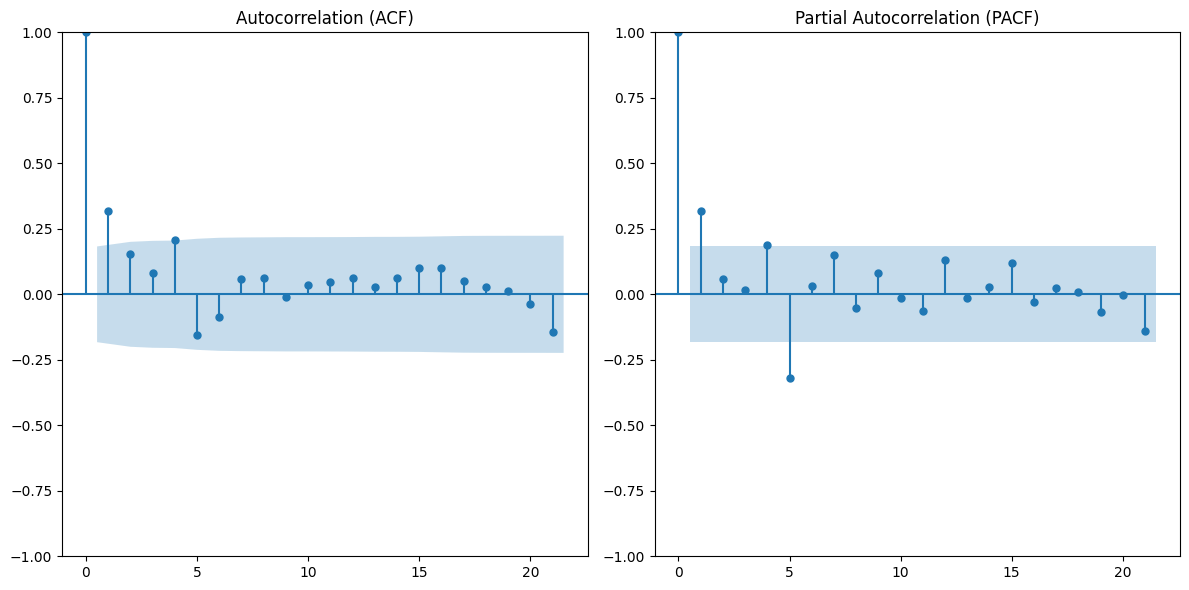

In [8]:
traindf=pd.DataFrame(train)

# Plot ACF and PACF for differenced data
plt.figure(figsize=(12, 6))

# ACF Plot
plt.subplot(1, 2, 1)
plot_acf(traindf, ax=plt.gca())
plt.title("Autocorrelation (ACF)")

# PACF Plot
plt.subplot(1, 2, 2)
plot_pacf(traindf, ax=plt.gca())
plt.title("Partial Autocorrelation (PACF)")

plt.tight_layout()
plt.show()

p=1 and q=1 or higher are good choice from the graph

In [9]:
model = ARIMA(train, seasonal_order=(1,0,1,52))
model_fit = model.fit()
print(model_fit.summary())

                                SARIMAX Results                                 
Dep. Variable:             Weekly_Sales   No. Observations:                  115
Model:             ARIMA(1, 0, [1], 52)   Log Likelihood               -1528.894
Date:                  Tue, 07 Oct 2025   AIC                           3065.788
Time:                          16:16:34   BIC                           3076.768
Sample:                               0   HQIC                          3070.245
                                  - 115                                         
Covariance Type:                    opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.552e+06   4.64e+04     33.448      0.000    1.46e+06    1.64e+06
ar.S.L52       0.5827      1.116      0.522      0.601      -1.604       2.769
ma.S.L52       0.0316      1.732    

In [13]:
history = [x for x in train['Weekly_Sales']]  # training values
predictions = []

for t in range(len(test)):
    # Fit ARIMA on available history
    model = ARIMA(history, seasonal_order=(1,0,1,52))  # adjust seasonal_order if needed
    model_fit = model.fit()

    # Forecast next point
    yhat = model_fit.forecast()[0]
    predictions.append(yhat)

    # Append actual observation to history
    obs = test.iloc[t]['Weekly_Sales']
    history.append(obs)

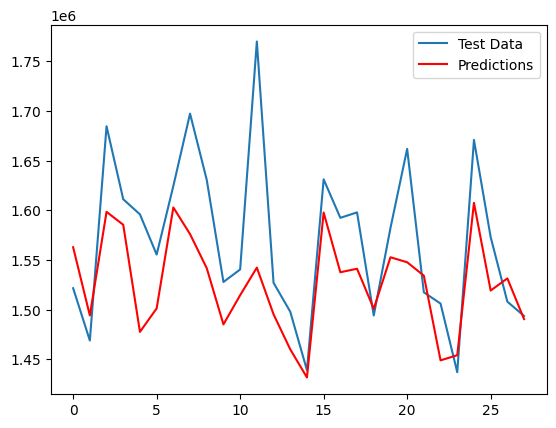

In [14]:
plt.plot(test, label='Test Data')
plt.plot(predictions, color='red', label='Predictions')
plt.legend()
plt.show()

In [15]:
print('Coefficient of determination: %.2f' % r2_score(test, predictions))

rmse = np.sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)

Coefficient of determination: 0.23
Test RMSE: 70637.372


Coefficient of determination(R²) = 0.23 the model explains 23% of the variance in weekly sales.
That’s low, which means most of the variation in weekly sales is not captured by your current model.

RMSE = Root Mean Squared Error(lower better